In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import signal
from math import exp
import processes.foundation as fd
from math import exp, sqrt, pi, erfc
from lmfit import Model
import csv
from scipy.optimize import curve_fit
import pywt
from statistics import median
import copy

In [14]:
def find_closest_idx(arr, val):
       idx = np.abs(arr - val).argmin()
       return idx

In [12]:
def find_idx(arr, val, idxBegin):
        for i in range(idxBegin, 0, -1):
            count = arr[i]
            if count <= val:
                break

        idx = i
        return idx

In [13]:
def find_idxr(arr, val, idxBegin):
        for i in range(idxBegin, len(arr)-1, 1):
            count = arr[i]
            if count >= val:
                break
        
        idx = i
        return idx

In [15]:
def sigPulseSpecific(riseMax, riseMin, Energy):
    rise = int((riseMax-riseMin)*np.random.random()+riseMin)
    energy = Energy



    pulse = np.zeros(15000)
    x = np.linspace(-rise-40,rise+40,2*rise+81)
    y = energy/(1 + np.exp(-x/(0.3*rise)))

    pulse[10000: 10000+len(x)] = y
    pulse[10000+len(x)::] = y[-1]

    max = np.amax(pulse)
    min = np.amin(pulse)
    m90 = max - (max-min)*0.10
    m10 = max - (max-min)*0.90
    imax9 = find_closest_idx(pulse, m90)
    imax1 = find_closest_idx(pulse, m10)
    rise = imax9 - imax1

    return pulse, rise

In [16]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line

j = 0
for energy in energy_lis:
    deltat = np.zeros(steps)
    rise_true = np.zeros(steps)
    rise_cal = np.zeros(steps)
    for i in range(0,steps):
        pulse, rise_true[i] = sigPulseSpecific(70,50,energy)
        wave1 = copy.deepcopy(wave)
        wp = wave1[0:15000] + pulse
        wp = wp - np.mean(wp[0:1000])
        max = np.mean(wp[11000:15000])
        min = np.amin(wp)
        m90 = max*0.9
        m10 = max*0.1
        m50 = max*0.5
        imax51 = find_idx(wp, m50, 11000)
        imax9 = find_idxr(wp, m90, imax51)
        imax1 = find_idx(wp, m10, imax51)
        rise_cal[i] = imax9 - imax1
        deltat[i] = abs(rise_cal[i] - rise_true[i])
    
    mean = sum(deltat)/len(deltat)
    variance = sum([((x - mean) ** 2) for x in deltat]) / len(deltat)
    sig[j] = variance ** 0.5
    j += 1

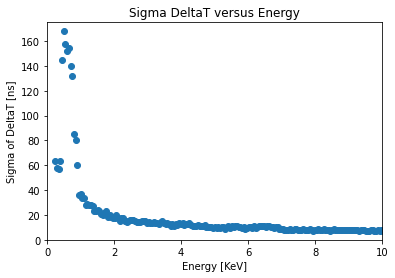

In [20]:
plt.scatter(energy_lis*0.0408625 -0.16892, sig*8)
plt.xlim(0,10)
plt.ylim(0,175)
plt.xlabel("Energy [KeV]")
plt.ylabel("Sigma of DeltaT [ns]")
plt.title("Sigma DeltaT versus Energy")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/sigTimeEnergyRange.pdf", facecolor = "white")
plt.show()

In [21]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line

j = 0
for energy in energy_lis:
    deltat = np.zeros(steps)
    rise_true = np.zeros(steps)
    rise_cal = np.zeros(steps)
    for i in range(0,steps):
        pulse, rise_true[i] = sigPulseSpecific(70,50,energy)
        wave1 = copy.deepcopy(wave)
        wp = wave1[0:15000] + pulse
        wp = wp - np.mean(wp[0:1000])
        max = np.mean(wp[11000:15000])
        min = np.amin(wp)
        m90 = max*0.9
        m10 = max*0.1
        m50 = max*0.5
        imax51 = find_idx(wp, m50, 11000)
        imax9 = find_idxr(wp, m90, imax51)
        imax1 = find_idx(wp, m10, imax51)
        rise_cal[i] = imax9 - imax1
        deltat[i] = abs(rise_cal[i] - rise_true[i])
    
    mean = sum(deltat)/len(deltat)
    variance = sum([((x - mean) ** 2) for x in deltat]) / len(deltat)
    sig[j] = variance ** 0.5
    j += 1

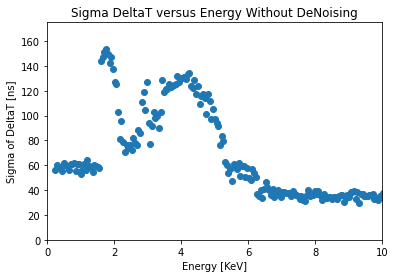

In [22]:
plt.scatter(energy_lis*0.0408625 -0.16892, sig*8)
plt.xlim(0,10)
plt.ylim(0,175)
plt.xlabel("Energy [KeV]")
plt.ylabel("Sigma of DeltaT [ns]")
plt.title("Sigma DeltaT versus Energy Without DeNoising")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/sigTimeEnergyRangeNoDeNoise.pdf", facecolor = "white")
plt.show()

In [ ]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
df = fd.get_df(run_list, "Card1")

energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line

j = 0
for energy in energy_lis:
    deltat = np.zeros(steps)
    rise_true = np.zeros(steps)
    rise_cal = np.zeros(steps)
    for i in range(0,steps):
        pulse, rise_true[i] = sigPulseSpecific(70,50,energy)
        wave1 = copy.deepcopy(wave)
        wp = wave1[0:15000] + pulse
        wp = wp - np.mean(wp[0:1000])
        max = np.mean(wp[11000:15000])
        min = np.amin(wp)
        m90 = max*0.9
        m10 = max*0.1
        m50 = max*0.5
        imax51 = find_idx(wp, m50, 11000)
        imax9 = find_idxr(wp, m90, imax51)
        imax1 = find_idx(wp, m10, imax51)
        rise_cal[i] = imax9 - imax1
        deltat[i] = abs(rise_cal[i] - rise_true[i])
    
    mean = sum(deltat)/len(deltat)
    variance = sum([((x - mean) ** 2) for x in deltat]) / len(deltat)
    sig[j] = variance ** 0.5
    j += 1

In [23]:
df = fd.get_df(run_list, "Card1")

In [24]:
df

,channel,timestamp,startEnergy,maxEnergy,trapEmax,tp_max,tp_50
0,0,34259632908387,134317535,27,6132.491699,152432.0,152432.0
1,0,34259633488287,134316413,4,4543.745605,138184.0,138184.0
2,0,34259633488287,134316413,4,4543.745605,138184.0,138184.0
3,0,34252175986278,134314664,4294967271,3940.395264,138176.0,138176.0
4,0,34252176131639,134315508,4294967250,4032.402100,138168.0,138168.0
...,...,...,...,...,...,...,...
8377,0,34260883511552,134313928,38,15076.475586,138552.0,138552.0
8378,0,34260880689449,134315145,3,4918.157715,138216.0,138216.0
8379,0,161806772310837,4294967295,4294967295,0.000000,0.0,NaN
8380,0,0,4294967295,4294967295,0.000000,0.0,NaN


In [25]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line

energy = 20

pulse, rise_true = sigPulseSpecific(70,50,energy)
wave1 = copy.deepcopy(wave)
wp = wave1[0:15000] + pulse
wp = wp - np.mean(wp[0:1000])
max = np.mean(wp[11000:15000])
min = np.amin(wp)
m90 = max*0.9
m10 = max*0.1
m50 = max*0.5
imax51 = find_idx(wp, m50, 11000)
imax9 = find_idxr(wp, m90, imax51)
imax1 = find_idx(wp, m10, imax51)
rise_cal = imax9 - imax1
deltat = abs(rise_cal - rise_true)

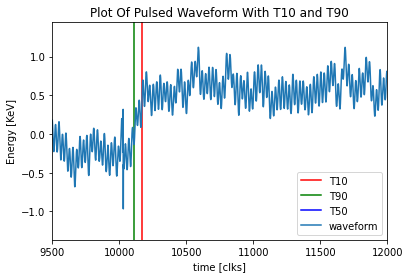

In [26]:
plt.axvline(x = imax9, color='r', label = 'T10')
plt.axvline(x = imax1, color='g', label = 'T90')
plt.axvline(x = df["tp_50"].iloc[1], color='b', label = 'T50')
plt.plot(wp*0.0408625 -0.16892, label="waveform")
plt.legend()
plt.xlim(9500,12000)
plt.xlabel("time [clks]")
plt.ylabel("Energy [KeV]")
plt.title("Plot Of Pulsed Waveform With T10 and T90")
#plt.rcParams['savefig.facecolor']='white'
#plt.rcParams['axes.facecolor']='white'
#plt.savefig("images/PulsedWaveform1KeV.pdf", facecolor = "white")
plt.show()